# PDE Modelling Mimic of 190413 experiment

## Objectives 
* Microscope movie was performed on 190413 that simply observed growth of a constitutively fluorescent strain on agar pads, varying in pad size and cell occupation
* Simulate each of the experimental setups executed
* eventually build into a fitting routine

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


In [2]:
# imports
# from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext memory_profiler
%load_ext line_profiler
import timeit

import seaborn as sns

# import bokeh
# from bokeh.plotting import figure, output_file, save
# from bokeh.io import output_notebook, show
# from bokeh import palettes, transform
# from bokeh.models import LogColorMapper, LogTicker, ColorBar, LinearColorMapper, Ticker
# output_notebook()

from IPython.display import HTML

pad_times_df = pd.read_csv('../../../microscope-movie-analysis/pad_times.csv')
pad_times_df = pad_times_df.loc[(pad_times_df.frame>=5)&(pad_times_df.frame<41),:]

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'DFDFE5'}

sns.set_context('paper', rc=rc)

%matplotlib inline

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

This is achieved though a bunch of subtractions between offset arrays.

Attempt fitting w/o crowding

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [135]:
#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

@numba.jit(nopython=True, cache=True)
def dhillda(a, n, k):
    h_ma = (n/k)*((a/k)**(n-1))*(1 / (1 + (a/k)**n)**2)
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

# @numba.jit(cache=True)
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0, dims, calc_f):
    species, n_h, n_w, scale= dims
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    y.shape = species*n_h*n_w
    return d_y.flatten()

solver = 'RK45'

def wrapper(dims, p0, initial_array, t_eval, atol, rtol, calc_f, jac):
#     print(solver)
    species, n_h, n_w, scale = dims
    args=(np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((n_h, n_w), dtype=np.float32,order='C'), 
          p0, dims, calc_f)
    initial_array.shape = n_h*n_w*species
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [t_eval.min(), t_eval.max()], initial_array.copy(), vectorized=True, method="BDF", 
                        atol=atol, rtol=rtol, t_eval=t_eval, jac=jac)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
#     print("nfev:{} njev:{}".format(out.nfev, out.njev))
    return exp_y, exp_t

# @numba.jit(cache=True)
def prep_pad_helper(scale, init_cells):
    scale_factor = (scale/4500)/(2.475/4)
    scaled_init = skimage.transform.rescale((init_cells>1).astype(np.float32), 
                                            scale_factor, 
                                            order=1, 
                                            mode='constant', 
                                            multichannel=False,
                                            preserve_range=True,
                                            cval=0)
    return scaled_init



# @numba.jit(cache=True)
def prep_pad_0(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_0_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==0,'time'].values

# @numba.jit(cache=True)
def prep_pad_1(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # middle colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_1_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # top colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_10_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((0, n_w-s_w))//2)
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==10,'time'].values

# @numba.jit(cache=True)
def prep_pad_2(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_2_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==2,'time'].values

# @numba.jit(cache=True)
def prep_pad_3(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_3_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    # first colony
    y0, x0 = np.array((n_h//2 - s_h//2, n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # duplicate on the opposite side for the second colony
    y0, x0 = np.array((n_h//2 - s_h//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==3,'time'].values

# @numba.jit(cache=True)
def prep_pad_4(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_4_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==4,'time'].values

# @numba.jit(cache=True)
def prep_pad_5(scale):
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # left colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_5_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # right colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_6_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==6,'time'].values


# @numba.jit(cache=True)
def prep_pad_6(scale):
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_7_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==7,'time'].values

# @numba.jit(cache=True)
def prep_pad_7(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_8_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==8,'time'].values
    
# @numba.jit(cache=True)
def prep_pad_8(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_9_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init, pad_times_df.loc[pad_times_df.pad==9,'time'].values

# try to make a jacobian function
# you'll likely need to use the vectorized version of the ODE, rather than the matrix version. 
# first, just see if you can use the sparsity structure matrix approach
def prep_jac(D_vec, p0, dims):
    dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps = p0
    species, n_h, n_w, scale = dims
    # Make jacobian array
    n_jac = n_h*n_w*species
    # jacobian terms:
    # diffusion : 5 per x,y point, minus 
    n_nz = n_jac*5 - 2*(n_h+n_w)*species # + 4*n_h*n_w
    data_vec = np.empty(n_nz,dtype=np.float32)
    j1_vec = np.empty(n_nz,dtype=np.int)
    j2_vec = np.empty(n_nz,dtype=np.int)
    f_ji = lambda x, y, spec : x + n_w*y + n_w*n_h*spec

    def assign_val(i, val, j1, j2):
        data_vec[i] = val
        j1_vec[i] = j1
        j2_vec[i] = j2
        return i+1
    
    i = 0
    # top diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(1,n_h):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y-1, spec)
                i = assign_val(i, val, j1, j2)

    # right diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h):
            for x in np.arange(0,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x+1, y, spec)
                i = assign_val(i, val, j1, j2)

    # bottom diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h-1):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y+1, spec)
                i = assign_val(i, val, j1, j2)

    # left diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(n_h):
            for x in np.arange(1,n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x-1, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, center
    for spec in np.arange(species):
        val = -4*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in np.arange(1,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, edges
    for spec in np.arange(species):
        val = -3*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)
        for x in np.arange(1,n_w-1):
            for y in [0,n_h-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, corners
    for spec in np.arange(species):
        val = -2*dx*D_vec[spec]
        for y in [0,n_h-1]:
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    dif_jac = (data_vec, j1_vec, j2_vec)

    #dc/(dcdt)
    dcdcdt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dc/(dndt)
    dcdndt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dndt)
    dndndt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dcdt)
    dndcdt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #ds/(dcdt)
    dsdcdt_indices = [(x, y, f_ji(x,y,s_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #ds/(dndt)
    dsdndt_indices = [(x, y, f_ji(x,y,s_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #ds/(dsdt)
    dsdsdt_indices = [(x, y, f_ji(x,y,s_i), f_ji(x,y,s_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    indices_list = [dcdcdt_indices, dcdndt_indices, dndndt_indices, dndcdt_indices, dsdcdt_indices, dsdndt_indices, dsdsdt_indices]
    
    #     @numba.jit(cache=True,nopython=True)
    def calc_jac(t, y):
        c_i, n_i, s_i = 0,1,2
        col_thresh = 1e-4
        n_terms = np.sum([len(xx) for xx in indices_list])
        data_vec = np.zeros(n_terms, dtype=np.float32)
        j1_vec = np.zeros(n_terms, dtype=np.int)
        j2_vec = np.zeros(n_terms, dtype=np.int)

        i = 0
        def assign_vals(indices, val_arr, i):
            for x1,y1,j1,j2 in indices:
                data_vec[i] = val_arr[y1,x1]
                j1_vec[i] = j1
                j2_vec[i] = j2
                return i+1

        #dc/(dcdt)
        nut_avail = hill(y[n_i,:,:], Hn, Kn)
        dnut_avail = dhillda(y[n_i,:,:], Hn, Kn)
        val_arr = rc*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dc/(dndt)
        val_arr = rc*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dndt)
        val_arr = -pn*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dcdt)
        val_arr = -pn*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #ds/(dcdt)
        val_arr = xs*(y[c_i,:,:]>col_thresh)
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #ds/(dndt)
        val_arr = -rc*y[s_i,:,:]*dnut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #ds/(dsdt)
        for x1,y1,j1,j2 in dsdsdt_indices:
    #         rxn_jac[j1,j2] = -ps
            data_vec[i] = -ps
            j1_vec[i] = j1
            j2_vec[i] = j2
            i += 1

        return data_vec, j1_vec, j2_vec

    #     @numba.jit(cache=True)
    def calc_jac_wrapper(t,y):
        dif_vec, j1_dif, j2_dif = dif_jac
        y.shape = (species,n_h,n_w)
        n_jac = species*n_h*n_w
        rxn_vec, j1_rxn, j2_rxn = calc_jac(t,y)
        data_vec = np.concatenate([dif_vec, rxn_vec])
        j1_vec = np.concatenate([j1_dif, j1_rxn])
        j2_vec = np.concatenate([j2_dif, j2_rxn])
        y.shape = species*n_w*n_h
        return sparse.coo_matrix((data_vec, (j1_vec,j2_vec)),dtype=np.float32)

    return calc_jac_wrapper
    
def prep_initial_array(p0, species, cell_init):
    dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps = p0
    c_i, n_i, s_i = np.arange(species)
    col_thresh = 1e-4
    n_h, n_w = cell_init.shape
    # Set initial conditions
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array[c_i,:,:] = cell_init
    initial_array[s_i,:,:] = np.greater(cell_init, col_thresh)*(xs/(rc+ps))
    return initial_array
    
def sim_pad_prep(p0, scale, prep_fn):
    # Calculate dx and redefine p0
    Dc, Dn, rc, Kn, Hn, pn, xs, ps = p0
    dx = np.power((scale/4.5),2)
    p0 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps])
    D_vec = [Dc, Dn, Dc]
    
    # Prep initial array
#     print('load initial cell frame')
    species = 3 # cells, nutrients, mscarlet
    cell_init, t_eval = prep_fn(scale)
    n_h, n_w = cell_init.shape
    initial_array = prep_initial_array(p0, species, cell_init)
#     print(initial_array.shape)
    col_thresh = 1e-4
    
    dims = [species, n_h, n_w, scale]
    c_i, n_i, s_i = np.arange(species)
    
    # Make empty array, and tolerance arrays
#     print('make tolerance arrays')
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    atol[c_i,:,:] = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    atol[s_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    # atol must be a vector for the solver
    atol.shape = species*n_h*n_w
    rtol = 1e-3
                             
    @numba.jit(cache=True,nopython=True)
    def calc_f(y, d_y, diff_terms, nut_avail, p0):
        c_i, n_i, s_i = np.arange(3)
        dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps = p0
        calc_diffusion(y, diff_terms)

        # Nutrient term
        nut_avail[:,:] = hill(y[n_i,:,:], Hn, Kn)

        # Cell growth and diffusion
        d_y[c_i,:,:] = (dx)*Dc*diff_terms[c_i,:,:] + rc * nut_avail * y[c_i,:,:]

        # Nutrient consumption
        d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - pn * nut_avail * y[c_i,:,:]
    
    calc_jac_wrapper = prep_jac(D_vec, p0, dims)
    
    return dims, p0, initial_array, t_eval, atol, rtol, calc_f, calc_jac_wrapper
#     return wrapper(dims, p0, initial_array, tmax, atol, rtol, calc_f, calc_jac_wrapper)

def sim_pad(p0, scale, prep_fn):
    return wrapper(*sim_pad_prep(p0, scale, prep_fn))


## Try to write a simple fitting routine comparing simulation to experiment directly


In [ ]:

# def fit_pad(pad_ind, scale):
mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
fn_list = [mask_fn_tmpl.format(pad,frame) for pad in [2] for frame in np.arange(5,41)]
im_arr = skimage.io.imread_collection(fn_list).concatenate()>1
scale = np.power(2,4)
scale_factor = (4/2.475)*(scale/4500)
sf = np.int(1/scale_factor)
im_dwn = skimage.transform.rescale(im_arr.astype(np.float32),(1.0,scale_factor,scale_factor),order=0, 
                                            mode='constant', 
                                            multichannel=False,
                                            preserve_range=True,
                                            cval=0)

y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
yslice = slice(y0,y1)
xslice = slice(x0,x1)


In [137]:

#             Dc,     Dn,   rc, Kn, Hn, pn, xs,   ps]
p0 = np.array([0, 3e-1, 1.5e-2, 75, 2, 80, 25, 1], dtype=np.float32)
Dc,     Dn,   rc, Kn, Hn, pn, xs,   ps = p0

def fit_fun(p_sub):
    Dn, Kn, Hn, pn = p_sub
    if np.any(p_sub<0):
        return np.inf
    p0 = np.array([Dc,     Dn,   rc, Kn, Hn, pn, xs,   ps])
    sim_arr, sim_tvc = sim_pad(p0,np.power(2,4).astype(np.int), prep_pad_2)
    return np.sum(np.power(im_dwn - sim_arr[:,0,yslice,xslice],2))

fit_fun(np.array([Dn, Kn, Hn, pn]))

410.5050853049754

In [148]:
%lprun -f sim_pad_prep fit_fun(np.array([Dn, rc, Kn, Hn, pn]))

In [149]:
%lprun -f wrapper fit_fun(np.array([Dn, rc, Kn, Hn, pn]))

In [138]:
fit_out = opt.minimize(fit_fun, np.array([Dn, rc, Kn, Hn, pn]))

In [143]:
fit_out

      fun: 39.11597040130986
 hess_inv: array([[ 9.99940582e-01,  7.70769487e-03, -6.42261510e-06,
        -4.21395273e-05, -5.46620599e-05],
       [ 7.70769487e-03,  1.56618379e-04,  8.33142633e-04,
         5.46634606e-03,  7.09077094e-03],
       [-6.42261510e-06,  8.33142633e-04,  9.99999306e-01,
        -4.55495934e-06, -5.90854896e-06],
       [-4.21395273e-05,  5.46634606e-03, -4.55495934e-06,
         9.99970114e-01, -3.87666793e-05],
       [-5.46620599e-05,  7.09077094e-03, -5.90854896e-06,
        -3.87666793e-05,  9.99949713e-01]])
      jac: array([ 1.66893005e-05, -1.47819519e-05,  0.00000000e+00,  3.81469727e-06,
        1.28746033e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 544
      nit: 1
     njev: 76
   status: 2
  success: False
        x: array([ 0.30778546, -0.99492915, 75.00084155,  2.00552149, 80.0071623 ])

In [144]:
np.save('fit_out.npy',fit_out)

In [145]:
fit_out.x - np.array([Dn, rc, Kn, Hn, pn])

array([ 7.78544482e-03, -1.00992915e+00,  8.41546835e-04,  5.52148695e-03,
        7.16229782e-03])

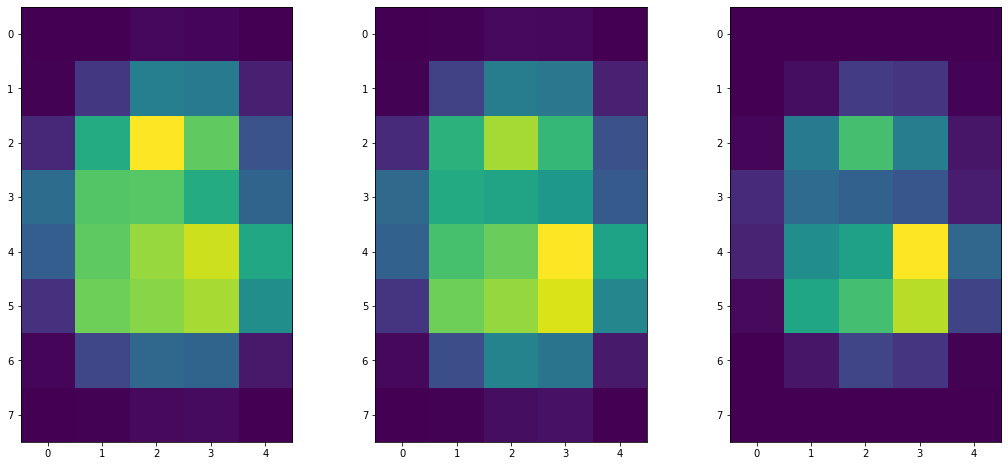

In [128]:
frame=20
fig, axs = plt.subplots(1,3,figsize=(18,8))
axs[0].imshow(im_dwn[frame,:,:])
_, s_h, s_w = im_dwn.shape
_, _, n_h, n_w = sim_arr.shape
y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
axs[1].imshow(sim_arr[frame,0,y0:y1,x0:x1])
axs[2].imshow(np.power(im_dwn[frame,:,:]-sim_arr[frame,0,y0:y1,x0:x1],2))

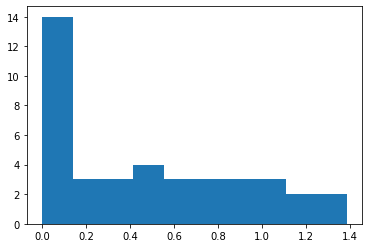

In [129]:
_ = plt.hist((sim_arr[frame,0,y0:y1,x0:x1]).flatten())

## You already deleted the cell but the scaling was good compared to the bioscrape approach

In [ ]:
for scale_power in [3,4,5,6,7,8]:
    print(scale_power)
    plt.figure()
    scale = np.power(2,scale_power).astype(np.int)
    init_state = prep_pad_2(scale)
    plt.imshow(init_state)
    plt.title(scale_power)


In [ ]:
# scale = 4
# p0 = np.array([1e-5, 3e-1, 2e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)
# Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0 = p0
# dx = np.power((scale/4.5),2)
# p1 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps, leak, od0])
# species, n_h, n_w, scale = dims
# # plt.imshow(calc_jac(0,initial_array.flatten())==0)
# # plt.imshow(calc_jac(0,initial_array.flatten())==0)
# n_vars = n_w*n_h*species
# initial_vec = initial_array.flatten()
# args=(np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
#       np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
#       np.zeros((n_h, n_w), dtype=np.float32,order='C'), 
#       p1)
# d_y, diff_terms, nut_avail, _ = args
# calc_lam = lambda y : calc_f(y,*args)
# %timeit calc_jac(0,initial_vec)
# # %timeit calc_diff_jac()
# # %timeit calc_jac(0,initial_array.flatten())
# # plt.imshow(jac_arr==0)
# # plt.figure(figsize=(20,20))
# # calc_arr = calc_jac(0,initial_array.flatten())
# # plt.imshow(calc_arr==0)
# # plt.figure(figsize=(20,20))
# # plt.imshow(np.isclose(jac_arr, calc_arr, 0.001))

In [ ]:
plt.close('all')
scale = np.power(2,5).astype(np.int)
tmax = 10*60

#Params :         Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0
p0 = np.array([1e-5, 3e-1, 1.5e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)
# Define parameter values to sample
Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0 = p0
rc_vec = [rc]
n_rc = len(rc_vec)
dn_vec = Dn*np.array([1e-2,1e-1])
n_dn = len(dn_vec)
kn_vec = [20,50,80]
n_kn = len(kn_vec)
pn_vec = [1,8,20]
n_pn = len(pn_vec)
od0_vec = [0.1,1]
n_od0 = len(od0_vec)
hn_vec = [1,2,3]
n_hn = len(od0_vec)

# Create parameter data frame
columns = 'Dc' ,'Dn' ,'rc' ,'Kn' ,'Hn' ,'pn' ,'xs' ,'ps' ,'leak' ,'od0'
index = np.arange(n_rc*n_dn*n_kn*n_pn*n_od0*n_hn)
p0_df = pd.DataFrame(columns=columns, index=index)

i = 0
for rc in rc_vec:
    for Dn in dn_vec:
        for Kn in kn_vec:
            for pn in pn_vec:
                for od0 in od0_vec:
                    for Hn in hn_vec:
                        p0_df.loc[i,:] = Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0
                        i += 1


# for scale_ind in np.arange(5,8):
#     for solver in ['RK45','LSODA']:
#         scale = np.power(2,scale_ind).astype(np.int)
#         print('scale:{} solver:{} pad0'.format(scale, solver))
#         %time sim_pad(p0_df.loc[0,:].values, scale, tmax, prep_pad_0)

# pad_fn_list = [prep_pad_0,prep_pad_1,prep_pad_2,prep_pad_3,prep_pad_4,prep_pad_5,prep_pad_6,prep_pad_7,prep_pad_8]
# for scale_ind in [3]:
#     for i, pad_fn in enumerate(pad_fn_list):
#         scale = np.power(2,scale_ind).astype(np.int)
#         print(scale, i)
#         %time sim_pad(p0_df.iloc[1,:].values, scale, tmax, pad_fn)
pad_fns = [prep_pad_0,prep_pad_1,prep_pad_2,prep_pad_3,prep_pad_4,prep_pad_5,prep_pad_6,prep_pad_7,prep_pad_8]    
def worker(p0_df):
#     pad_fns = [prep_pad_0,prep_pad_1,prep_pad_2,prep_pad_3,prep_pad_4,prep_pad_5,prep_pad_6,prep_pad_7,prep_pad_8]
    pad_fns = [prep_pad_0,prep_pad_2,prep_pad_8]
    for p0_ind in p0_df.index:
        p0 = p0_df.loc[p0_ind,:].values
        for pad_ind, pad_fn in enumerate(pad_fns):
            out = sim_pad(p0, scale, tmax, pad_fn)
            np.save('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind), out[0])
            np.save('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind), out[1])
#             anim = write_movie(out[0], out[1])
#             anim.save('worker_outputs//animation_pad{}_p{}.gif'.format(pad_ind,p0_ind), writer='pillow')    
    
jobs = []
n_proc = 4
# for i in range(n_proc):
#     p = Process(target=worker, args=(p0_df[i::n_proc].copy(),))
#     jobs.append(p)
#     p.start()
# p.join()
sim_df = pd.DataFrame(itt.product(p0_df.index.values, np.arange(len(pad_fns))), columns=['p_ind','pad_ind'])
# plt.figure(figsize=(20,20))
# plt.imshow(prep_pad_4(scale))


In [ ]:
c_i, n_i, s_i = np.arange(3)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = [c_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    indxs = [s_i]
    v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [c_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


In [ ]:
plt.close('all')
pad_size = []
gb_p = sim_df.groupby('p_ind')
for p0_ind in p0_df.index:
    plt.figure()
    sub_df = gb_p.get_group(p0_ind)
    for pad_ind in sub_df.pad_ind.values:
        tvec_fn, avec_fn = p0_df.loc[p0_ind, ['pad{}_avec_fn'.format(pad_ind), 'pad{}_tvec_fn'.format(pad_ind)]]
        if 'na' in [tvec_fn, avec_fn]:
            pass
        else:
            img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind))
            t_vec = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind))
        #     plt.figure()
        #     dy_vec = (np.diff(img[:,c_i,:,:],axis=0)/img[1:,c_i,:,:]).flatten('F')
            c_vec = img[:,c_i,:,:].sum(axis=-1).sum(axis=-1)
            dy_vec = np.diff(c_vec)/np.diff(t_vec)/c_vec[:-1]
            tc_ind = np.arange(len(dy_vec))[dy_vec<0.8*dy_vec.max()]
            if len(tc_ind) == 0:
                tc_ind = len(dy_vec)-1
            else:
                tc_ind = tc_ind[0]
        #     dy_t_vec = np.tile(t_vec[1:], len(dy_vec)//len(t_vec[1:]))
            plt.plot(img.shape[2], t_vec[tc_ind]/60,'o',label=pad_ind)
            plt.title('Simulation threshold crossings {}'.format(p0_ind))
#     plt.legend()
    plt.tight_layout()
    plt.xlabel('Pad size')
    plt.ylabel('Threshold crossing (minutes)')
#     plt.ylim([-1,3])


In [ ]:
def tiff_worker(sim_df):
    for ind in sim_df.index:
        p_ind, pad_ind = sim_df.loc[ind,['p_ind','pad_ind']]
        img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p_ind))
        tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p_ind))
        anim = write_movie(img, tvc)
        anim.save('worker_outputs/animation_pad{}_p{}.gif'.format(pad_ind,p_ind), writer='pillow')    


        
jobs = []
n_proc = 12
for i in range(n_proc):
    p = Process(target=gif_worker, args=(sim_df[i::n_proc].copy(),))
    jobs.append(p)
    p.start()
# p.join()


In [ ]:
def gif_worker(sim_df):
    for ind in sim_df.index:
        p_ind, pad_ind = sim_df.loc[ind,['p_ind','pad_ind']]
        img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p_ind))
        tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p_ind))
        anim = write_movie(img, tvc)
        anim.save('worker_outputs/animation_pad{}_p{}.gif'.format(pad_ind,p_ind), writer='pillow')    

jobs = []
n_proc = 12
# for i in range(n_proc):
#     p = Process(target=gif_worker, args=(sim_df[i::n_proc].copy(),))
#     jobs.append(p)
#     p.start()
# p.join()


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(skimage.transform.downscale_local_mean(img[5,c_i,:,:],(2,2)))

In [ ]:
skimage.transform.downscale_local_mean?

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(out[0][-1,c_i,:,:])

In [ ]:
p_ind, pad_ind = 4, 1
img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p_ind))
tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p_ind))
plt.figure(figsize=(10,10))
plt.imshow(img[-1,0,:,:])

# Fitting nutrient dynamics
You have produced smoothed curves capturing the trends of growth rate vs distance from colony center. These curves appear to match those of your simulations, as both simulated and experimental pads appear to develop nutrient wells in the center of the colonies. 
Try to find the best fit of your coarse-grained simulations to the nutrient growth models. 

## Viewing radius-rate profiles from experiments

In [ ]:
import seaborn as sns
import statsmodels as stm


def conv_cart_to_polar(x_vec, y_vec):
    # Convert vectors to polar coords
    phi_vec = np.ones(x_vec.shape,dtype=np.float)*np.pi/2
    quad_inds = (x_vec==0 )&(y_vec<0)
    if np.any(quad_inds):
        phi_vec[quad_inds] = 3*np.pi/2
    quad_inds = x_vec > 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    quad_inds = x_vec < 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.pi + np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    phi_vec[phi_vec<0] = phi_vec[phi_vec<0]+2*np.pi
    r_vec = np.sqrt(np.power(y_vec,2) + np.power(x_vec,2))
    return phi_vec, r_vec


smooth_rate_profiles_df = pd.read_csv('../../../microscope-movie-analysis/smooth_rate_profiles_df.csv')
smooth_rate_profiles_df = smooth_rate_profiles_df.astype({'pad':'int','frame':'int'})

In [ ]:

n_poly = 7
n_pads = 11
pad_size_vec = np.power(np.array([2,2,2,3,3,5,5,5,3,2,2]),2)
col_size_vec = np.power(np.array([2,2,1,2,2,2,2,2,3,3,2]),2)
pad_share_vec = np.array([0,1,0,1,0,1,1,0,0,0,1])
pad_info_columns = ['pad', 'pad_size', 'col_size', 'pad_share']
fit_info_columns = ['f_max', 'r0', 'r1']
poly_fit_columns = ['a{}'.format(xx) for xx in np.arange(n_poly+1)[::-1]]
columns = pad_info_columns + fit_info_columns + poly_fit_columns
fit_df = pd.DataFrame(index=np.arange(n_pads),columns=columns)
fit_df.loc[:,'pad'] = np.arange(n_pads)
fit_df.loc[:,'pad_size'] = pad_size_vec
fit_df.loc[:,'col_size'] = col_size_vec
fit_df.loc[:,'pad_share'] = pad_share_vec
fit_df[pad_info_columns]

In [ ]:
plot_df = smooth_rate_profiles_df.loc[(smooth_rate_profiles_df.frame>=15)&
                                   (smooth_rate_profiles_df.frame<=42)&
                                   (np.mod(smooth_rate_profiles_df.frame,3)==0),:]
plot_df = plot_df.loc[False==np.isnan(plot_df.rate.values),:]
# g = sns.FacetGrid(data=plot_df, row='pad',col='frame')
# g.set(ylim=(0,0.0003))
# g.map(sns.scatterplot,'rad', 'rate', 'log_area')
gb_pad_size = fit_df.loc[slice(0,9),['pad','pad_size']].groupby('pad_size')
plot_gb_pad = plot_df.groupby('pad')
for pad_size, pad_df in gb_pad_size:
#     plt.figure(figsize=(20,18))
    sub_plot_df = pd.concat([plot_gb_pad.get_group(xx) for xx in pad_df.pad.values])
    g = sns.lmplot(data=sub_plot_df, y='rate', x='rad', hue='pad',col='frame',fit_reg=False,
                   aspect=0.6,height=5,line_kws={'lw':6})
    g.set(ylim=(-5e-5,3.5e-4), xlim=(-50,1750), ylabel='{}\nrate'.format(pad_size))

## Viewing radius-rate profiles from simulations

In [ ]:
# exp pads 8 7 6 4 3 2 0
# sim pads 2 8 7 4 3 1 0
for exp_frame in [15,20,25,30,35]:
    plt.figure()
    exp_to_sim_pad_dict = dict(zip([0,2,8],
                                   [0,1,2]))
#     exp_to_sim_pad_dict = dict(zip([9,8,7,4,3,2,0],
#                                    [8,7,6,4,3,2,0]))
    gb_pad_frame = smooth_rate_profiles_df.groupby(['pad', 'frame'])
    pad, frame, param_i = 8, exp_frame, 11
    pad_ind = exp_to_sim_pad_dict[pad]
    exp_df = gb_pad_frame.get_group((pad, frame))
    exp_time = exp_df['time'].values[0]
    plt.plot(exp_df.rad*1.623, 100*exp_df.rate/0.00025, label='exp', lw=3)
    c_i, n_i, s_i = np.arange(3)
    scale_factor = (scale/4500)
    for param_i in np.arange(0,p0_df.shape[0],2):
        img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, param_i))
        tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, param_i))*60
        time_diff_vec = np.abs(tvc-exp_time)
        sim_frame = np.arange(len(tvc))[time_diff_vec==time_diff_vec.min()]
        time_val = tvc[sim_frame]
        
        _, _, h, w = img.shape
        x_vec, y_vec = np.array(list(itt.product(np.arange(h)-h/2, np.arange(w)-w/2))).T / scale_factor
        nut_vals = img[sim_frame,n_i,:,:].flatten()
        
        phi_vec, rad_vec = conv_cart_to_polar(x_vec, y_vec)
        lowess_rad, lowess_nut = stm.nonparametric.smoothers_lowess.lowess(nut_vals, rad_vec).T
        
        plt.plot(lowess_rad, lowess_nut,label='sim {}'.format(param_i))
    plt.legend()
    plt.title('Pad{} frame{}'.format(pad, frame))
    plt.ylim([-5,105])


In [ ]:
# exp pads 8 7 6 4 3 2 0
# sim pads 2 8 7 4 3 1 0
for pad in [0,2,8]:
    plt.figure()
    for frame in [15,25,35]:
        exp_to_sim_pad_dict = dict(zip([0,2,8],
                                       [0,1,2]))
    #     exp_to_sim_pad_dict = dict(zip([9,8,7,4,3,2,0],
    #                                    [8,7,6,4,3,2,0]))
        gb_pad_frame = smooth_rate_profiles_df.groupby(['pad', 'frame'])
        pad_ind = exp_to_sim_pad_dict[pad]
        exp_df = gb_pad_frame.get_group((pad, frame))
        exp_time = exp_df['time'].values[0]
        plt.plot(exp_df.rad*1.623, 100*exp_df.rate/0.00025, label='exp', lw=3)
        c_i, n_i, s_i = np.arange(3)
        scale_factor = (scale/4500)
        for param_i in [5]:
            img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, param_i))
            tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, param_i))*60
            time_diff_vec = np.abs(tvc-exp_time)
            sim_frame = np.arange(len(tvc))[time_diff_vec==time_diff_vec.min()]
            time_val = tvc[sim_frame]

            _, _, h, w = img.shape
            x_vec, y_vec = np.array(list(itt.product(np.arange(h)-h/2, np.arange(w)-w/2))).T / scale_factor
            nut_vals = img[sim_frame,n_i,:,:].flatten()

            phi_vec, rad_vec = conv_cart_to_polar(x_vec, y_vec)
            lowess_rad, lowess_nut = stm.nonparametric.smoothers_lowess.lowess(nut_vals, rad_vec).T

            plt.plot(lowess_rad, lowess_nut,label='sim {}'.format(param_i))
        plt.legend()
        plt.title('Pad{} frame{}'.format(pad, frame))
        plt.ylim([-5,105])


In [ ]:
p0_df

In [ ]:
p0_df.loc[[16,6,12,8],:]

In [ ]:
p0_df.loc[[4,14,0,2,10],:]

## Fitting growth model to experimental data through comparisons of the radial dependence of nutrient availability over time

* 

## Testing the comparaibility of no-cell-diffusion, low-resolution simulations to downsampled experimental images / growth rate in downsampled pixels

In [ ]:
#  Dc, Dn,   rc,  Kn, Hn, pn, xs,  ps, leak, od0]
p0 = np.array([0, 3e-1, 2e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)
# dims, _, initial_array, tmax, _, _, calc_f, calc_jac = sim_pad(p0,np.power(2,3).astype(np.int), 10*60, prep_pad_0)
# # out = calc_f()
scale = np.power(2,4).astype(np.int)
sim_arr, sim_tvc = sim_pad(p0,scale, 10*60, prep_pad_2)

files_df = pd.read_csv('../../../microscope-movie-analysis/stitched_files_df.csv', index_col=0)
pad2_df = files_df.loc[files_df.pad==2,:]
cols = ['pad', 'frame', 'mask', 'next_mask', 'fluor', 'size', 'lineage', 'time']
lineages_df = pd.read_csv('../../../microscope-movie-analysis/worker_outputs/lineage_results_all.csv',usecols=cols)
pad_times_df = lineages_df[['pad','frame','time']].groupby(['pad','frame']).agg(np.min).reset_index()
pad2_times = pad_times_df.loc[pad_times_df.pad==2,:]
pad2_df.loc[:,'time'] = pad2_times.time.values
cor_pos_df = pd.read_csv('../../../microscope-movie-analysis/pos_df.csv', index_col=0)
exp_arr = skimage.io.imread_collection(pad2_df.fn, conserve_memory=True)
exp_tvc = pad2_df.time.values

sim_keep_inds = np.zeros(exp_tvc.shape,dtype=np.int)
inds_vec = np.arange(len(sim_tvc))
for i in np.arange(len(exp_tvc)):
    diff_vec = np.abs(exp_tvc[i] - sim_tvc*60)
    match_ind = inds_vec[diff_vec.min() == diff_vec][0]
    sim_keep_inds[i] = match_ind

sim_arr = sim_arr[sim_keep_inds,:,:,:]
sim_tvc = sim_tvc[sim_keep_inds]

In [ ]:
c_i, n_i, s_i = np.arange(3)
def write_movie(pad, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = [c_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    indxs = [s_i]
    v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [c_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


In [ ]:
frame_time_by_pad = smooth_rate_profiles_df[['pad','frame','time']].groupby(['pad','frame']).agg(np.min)

def get_mask_movie(pad, frames):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    fn_list = [mask_fn_tmpl.format(pad, f) for f in frames]
    img = skimage.io.imread_collection(fn_list).concatenate()
    img_occ = img>1
    return img_occ

def get_mask_img(pad, frame):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    mask_fn = mask_fn_tmpl.format(pad,frame)
    img = skimage.io.imread(mask_fn)
    img_occ = img>1
    return img_occ


def downsample_mask_movie(exp_arr, scale):
    scale_factor = (4/2.475)*(scale/4500)
    img_dwn = skimage.transform.rescale(exp_arr.astype(np.float32), 
                                                [1,scale_factor,scale_factor], 
                                                order=1, 
                                                mode='constant', 
                                                multichannel=False,
                                                cval=0)
    return img_dwn

def get_downsampled_mask_img(pad, frame, scale):
    img_occ = get_mask_img(pad, frame)
    scale_factor = (4/2.475)*(scale/4500)
    img_dwn = skimage.transform.rescale(img_occ.astype(np.float32), 
                                                scale_factor, 
                                                order=1, 
                                                mode='constant', 
                                                multichannel=False,
                                                cval=0)
    return img_dwn

def match_sim_timepoints(sim_arr, sim_tvc, exp_tvc):
    n_exp_frames = len(exp_tvc)
    frames_vec = np.arange(len(sim_tvc))
    keep_inds = np.zeros(n_exp_frames, dtype=np.int)
    for i in np.arange(n_exp_frames):
        diff_vec = np.abs(sim_tvc - exp_tvc[i])
        keep_inds[i] = frames_vec[diff_vec==diff_vec.min()][0]
    return sim_arr[keep_inds,:,:,:], sim_tvc[keep_inds]

def rate_estimate_from_movie(exp_arr, exp_tvc):
    t, h, w = exp_arr.shape
    t_arr = np.tile(np.reshape(exp_tvc,(t,1,1)),(1,h,w))
    img_diff_arr = np.diff(exp_arr,axis=0)
    tvc_diff_arr = np.diff(t_arr, axis=0)
    rate_arr = img_diff_arr / (tvc_diff_arr * exp_arr[:-1,:,:])
    return rate_arr

def mask_movie_to_polar_nutrient_trajectories(exp_arr, exp_tvc):
    t, h, w = exp_arr.shape
    t_arr = np.tile(np.reshape(exp_tvc,(t,1,1)),(1,h,w))
    rate_arr = rate_estimate_from_movie(exp_arr, exp_tvc)
    x_arr = np.tile(np.arange(w),(t-1,h,w)) - w/2
    y_arr = np.tile(np.tile(np.arange(h),(w,1)).T,(t-1,1,1)) - h/2
    phi_vec, rad_vec = conv_cart_to_polar(x_arr.flatten(), y_arr.flatten())
    return rate_arr.flatten(), phi_vec, rad_vec, t_arr[:-1,:,:].flatten()

# def diff_arr_to_polar_nutrient_trajectories(diff_arr, exp_tvc):
    

    
# fig, axs = plt.subplots(1,3)
# axs[0].imshow(img_dwn)
# axs[0].set_xticks([]); axs[0].set_yticks([])
# axs[1].imshow(sim_arr[frame,c_i,12:20,14:20])
# axs[1].set_xticks([]); axs[1].set_yticks([])
# axs[2].imshow(img_occ)
# axs[2].set_xticks([]); axs[2].set_yticks([])

In [ ]:
exp_tvc = frame_time_by_pad.loc[2,'time'].values
exp_frames = frame_time_by_pad.loc[2,:].index.values
exp_arr = get_mask_movie(2,frames=exp_frames)

In [ ]:
diff_arr = rate_estimate_from_movie(downsample_mask_movie(exp_arr, np.power(2,5)), exp_tvc)

In [ ]:
pad_ind = 1
param_i = 4
sim_arr = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, param_i))
sim_tvc = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, param_i))*60

sim_arr, sim_tvc = match_sim_timepoints(sim_arr, sim_tvc, exp_tvc)

In [ ]:
sim_diff_arr = rate_estimate_from_movie(sim_arr[:,0,:,:], sim_tvc)

In [ ]:
sim_diff_arr[sim_diff_arr<=0] = np.nan

In [ ]:
plt.imshow(sim_diff_arr[12,:,:]*(sim_arr[12,0,:,:]>1e-4))

## Try rewriting into class-based approach to simulation to speed up fitting

In [6]:
#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

@numba.jit(nopython=True, cache=True)
def dhillda(a, n, k):
    h_ma = (n/k)*((a/k)**(n-1))*(1 / (1 + (a/k)**n)**2)
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

# @numba.jit(cache=True)
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0, dims, calc_f):
    species, n_h, n_w, scale= dims
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    y.shape = species*n_h*n_w
    return d_y.flatten()

def wrapper(dims, p0, initial_array, t_eval, atol, rtol, calc_f, jac):
#     print(solver)
    species, n_h, n_w, scale = dims
    args=(np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((n_h, n_w), dtype=np.float32,order='C'), 
          p0, dims, calc_f)
    initial_array.shape = n_h*n_w*species
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [t_eval.min(), t_eval.max()], initial_array.copy(), vectorized=True, method="BDF", 
                        atol=atol, rtol=rtol, t_eval=t_eval, jac=jac)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
#     print("nfev:{} njev:{}".format(out.nfev, out.njev))
    return exp_y, exp_t

# @numba.jit(cache=True)
def prep_pad_helper(scale, init_cells):
    scale_factor = (scale/4500)/(2.475/4)
    scaled_init = skimage.transform.rescale((init_cells>1).astype(np.float32), 
                                            scale_factor, 
                                            order=1, 
                                            mode='constant', 
                                            multichannel=False,
                                            preserve_range=True,
                                            cval=0)
    return scaled_init

# @numba.jit(cache=True)
def prep_pad_0(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(0,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==0,'time'].values
    fn_list = [mask_fn_tmpl.format(0,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_1(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # middle colony
    img_fn = mask_fn_tmpl.format(1,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # top colony
    img_fn = mask_fn_tmpl.format(10,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((0, n_w-s_w))//2)
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==10,'time'].values
    fn_list = [mask_fn_tmpl.format(10,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_2(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(2,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==2,'time'].values
    fn_list = [mask_fn_tmpl.format(2,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_3(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(3,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    # first colony
    y0, x0 = np.array((n_h//2 - s_h//2, n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # duplicate on the opposite side for the second colony
    y0, x0 = np.array((n_h//2 - s_h//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==3,'time'].values
    fn_list = [mask_fn_tmpl.format(3,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_4(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(4,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==4,'time'].values
    fn_list = [mask_fn_tmpl.format(4,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_5(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # left colony
    img_fn = mask_fn_tmpl.format(5,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # right colony
    img_fn = mask_fn_tmpl.format(6,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==6,'time'].values
    fn_list = [mask_fn_tmpl.format(6,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list


# @numba.jit(cache=True)
def prep_pad_6(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(7,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==7,'time'].values
    fn_list = [mask_fn_tmpl.format(7,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# @numba.jit(cache=True)
def prep_pad_7(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(8,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==8,'time'].values
    fn_list = [mask_fn_tmpl.format(8,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list
    
# @numba.jit(cache=True)
def prep_pad_8(scale):
    mask_fn_tmpl = '../../../microscope-movie-analysis/worker_outputs/masks/pad_{}_frame_{}.tif'
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = mask_fn_tmpl.format(9,5)
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    del init_cells
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    t_eval = pad_times_df.loc[pad_times_df.pad==9,'time'].values
    fn_list = [mask_fn_tmpl.format(9,frame) for frame in np.arange(5,41)]
    return cell_init, t_eval, fn_list

# try to make a jacobian function
# you'll likely need to use the vectorized version of the ODE, rather than the matrix version. 
# first, just see if you can use the sparsity structure matrix approach
def prep_jac(D_vec, p0, dims):
    dx, Dc, Dn, rc, Kn, Hn, pn = p0
    species, n_h, n_w, scale = dims
    c_i, n_i = np.arange(species)
    # Make jacobian array
    n_jac = n_h*n_w*species
    # jacobian terms:
    # diffusion : 5 per x,y point, minus 
    n_nz = n_jac*5 - 2*(n_h+n_w)*species # + 4*n_h*n_w
    data_vec = np.empty(n_nz,dtype=np.float32)
    j1_vec = np.empty(n_nz,dtype=np.int)
    j2_vec = np.empty(n_nz,dtype=np.int)
    f_ji = lambda x, y, spec : x + n_w*y + n_w*n_h*spec

    def assign_val(i, val, j1, j2):
        data_vec[i] = val
        j1_vec[i] = j1
        j2_vec[i] = j2
        return i+1
    
    i = 0
    # top diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(1,n_h):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y-1, spec)
                i = assign_val(i, val, j1, j2)

    # right diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h):
            for x in np.arange(0,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x+1, y, spec)
                i = assign_val(i, val, j1, j2)

    # bottom diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(0,n_h-1):
            for x in np.arange(n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y+1, spec)
                i = assign_val(i, val, j1, j2)

    # left diffsion
    for spec in np.arange(species):
        val = dx*D_vec[spec]
        for y in np.arange(n_h):
            for x in np.arange(1,n_w):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x-1, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, center
    for spec in np.arange(species):
        val = -4*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in np.arange(1,n_w-1):
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, edges
    for spec in np.arange(species):
        val = -3*dx*D_vec[spec]
        for y in np.arange(1,n_h-1):
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)
        for x in np.arange(1,n_w-1):
            for y in [0,n_h-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    # center diffusion, corners
    for spec in np.arange(species):
        val = -2*dx*D_vec[spec]
        for y in [0,n_h-1]:
            for x in [0,n_w-1]:
                j1 = f_ji(x, y, spec)
                j2 = f_ji(x, y, spec)
                i = assign_val(i, val, j1, j2)

    dif_jac = (data_vec, j1_vec, j2_vec)

    #dc/(dcdt)
    dcdcdt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dc/(dndt)
    dcdndt_indices = [(x, y, f_ji(x,y,c_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dndt)
    dndndt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,n_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    #dn/(dcdt)
    dndcdt_indices = [(x, y, f_ji(x,y,n_i), f_ji(x,y,c_i)) for x in np.arange(n_w) for y in np.arange(n_h)]

    indices_list = [dcdcdt_indices, dcdndt_indices, dndndt_indices, dndcdt_indices]
    
    #     @numba.jit(cache=True,nopython=True)
    def calc_jac(t, y):
        c_i, n_i = 0,1
        col_thresh = 1e-4
        n_terms = np.sum([len(xx) for xx in indices_list])
        data_vec = np.zeros(n_terms, dtype=np.float32)
        j1_vec = np.zeros(n_terms, dtype=np.int)
        j2_vec = np.zeros(n_terms, dtype=np.int)

        i = 0
        def assign_vals(indices, val_arr, i):
            for x1,y1,j1,j2 in indices:
                data_vec[i] = val_arr[y1,x1]
                j1_vec[i] = j1
                j2_vec[i] = j2
                return i+1

        #dc/(dcdt)
        nut_avail = hill(y[n_i,:,:], Hn, Kn)
        dnut_avail = dhillda(y[n_i,:,:], Hn, Kn)
        val_arr = rc*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dc/(dndt)
        val_arr = rc*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dndt)
        val_arr = -pn*dnut_avail*y[c_i,:,:]
        i = assign_vals(dcdcdt_indices, val_arr,i)

        #dn/(dcdt)
        val_arr = -pn*nut_avail
        i = assign_vals(dcdcdt_indices, val_arr,i)

        return data_vec, j1_vec, j2_vec

    #     @numba.jit(cache=True)
    def calc_jac_wrapper(t,y):
        dif_vec, j1_dif, j2_dif = dif_jac
        y.shape = (species,n_h,n_w)
        n_jac = species*n_h*n_w
        rxn_vec, j1_rxn, j2_rxn = calc_jac(t,y)
        data_vec = np.concatenate([dif_vec, rxn_vec])
        j1_vec = np.concatenate([j1_dif, j1_rxn])
        j2_vec = np.concatenate([j2_dif, j2_rxn])
        y.shape = species*n_w*n_h
        return sparse.coo_matrix((data_vec, (j1_vec,j2_vec)),dtype=np.float32)

    return calc_jac_wrapper
    
def prep_initial_array(species, cell_init):
    c_i, n_i = np.arange(species)
    col_thresh = 1e-4
    n_h, n_w = cell_init.shape
    # Set initial conditions
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array[c_i,:,:] = cell_init
    return initial_array
    
def sim_pad_prep(scale, prep_fn):
    species = 2 # cells, nutrients, mscarlet
    cell_init, t_eval, fn_list = prep_fn(scale)
    n_h, n_w = cell_init.shape
    initial_array = prep_initial_array(species, cell_init)
#     print(initial_array.shape)
    col_thresh = 1e-4
    
    dims = [species, n_h, n_w, scale]
    c_i, n_i = np.arange(species)
    
    # Make empty array, and tolerance arrays
#     print('make tolerance arrays')
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    atol[c_i,:,:] = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    # atol must be a vector for the solver
    atol.shape = species*n_h*n_w
    rtol = 1e-3
    
    return dims, initial_array, t_eval, atol, rtol, fn_list

def make_sim_functions(p0, scale, dims):
    # Calculate dx and redefine p0
    Dc, Dn, rc, Kn, Hn, pn = p0
    dx = np.power((scale/4.5),2)
    p0 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn])
    D_vec = [Dc, Dn, Dc]
    
    @numba.jit(cache=True,nopython=True)
    def calc_f(y, d_y, diff_terms, nut_avail, p0):
        c_i, n_i = np.arange(2)
        dx, Dc, Dn, rc, Kn, Hn, pn = p0
        calc_diffusion(y, diff_terms)

        # Nutrient term
        nut_avail[:,:] = hill(y[n_i,:,:], Hn, Kn)

        # Cell growth and diffusion
        d_y[c_i,:,:] = (dx)*Dc*diff_terms[c_i,:,:] + rc * nut_avail * y[c_i,:,:]

        # Nutrient consumption
        d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - pn * nut_avail * y[c_i,:,:]

    calc_jac_wrapper = prep_jac(D_vec, p0, dims)
    
    return calc_f, calc_jac_wrapper
#     return wrapper(dims, p0, initial_array, tmax, atol, rtol, calc_f, calc_jac_wrapper)

def sim_pad(p0, scale, prep_fn):
    return wrapper(*sim_pad_prep(p0, scale, prep_fn))

class Simulator(object):
    p0 = np.array([0, 5e-3, 2.5e-4, 50, 2, 0.5], dtype=np.float32)
    scale = np.power(2,4)
    dx = np.power((np.power(2,4)/4.5),2)
    
    def __init__(self, prep_fn, scale):
        dims, initial_array, t_eval, atol, rtol, fn_list = sim_pad_prep(scale, prep_fn)
        self.dims = dims
        self.initial_array = initial_array
        self.t_eval = t_eval
        self.atol = atol
        self.rtol = rtol
        self.dx = np.power(scale/4.5,2)
        self.scale = scale
        self.fn_list = fn_list
            
    def load_exp_data(self):
        im_arr = skimage.io.imread_collection(self.fn_list).concatenate()>1
        scale_factor = (4/2.475)*(self.scale/4500)
        sf = np.int(1/scale_factor)
        im_dwn = skimage.transform.rescale(im_arr.astype(np.float32),
                                           (1.0,scale_factor,scale_factor),
                                           order=0, 
                                           mode='constant', 
                                           multichannel=False,
                                           preserve_range=True,
                                           cval=0)
        
        self.exp_arr = im_dwn
        
    def load_exp_data_from_file(self, fn):
            self.exp_arr = skimage.io.imread(fn)
            
    def sim(self, p0):
        calc_f, calc_jac_wrapper = make_sim_functions(p0, self.scale, self.dims)
        dx = np.power((np.power(2,4)/4.5),2)
        Dc, Dn, rc, Kn, Hn, pn = p0
        p0 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn])
        sim_arr, sim_tvc = wrapper(self.dims, p0, self.initial_array, self.t_eval, self.atol, self.rtol, 
                calc_f, calc_jac_wrapper)
        return sim_arr, sim_tvc
    
    def fit_fun(self, p_sub):
        Dc, Dn, rc, Kn, Hn, pn = self.p0
        Dn, rc, Kn, Hn, pn = p_sub
        if np.any(p_sub<0):
            return np.inf
        p0 = np.array([Dc,Dn,rc,Kn,Hn,pn])
        sim_arr, sim_tvc = self.sim(p0)        
        _, _, n_h, n_w = sim_arr.shape
        _, s_h, s_w = self.exp_arr.shape
        y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
        y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
        yslice = slice(y0,y1)
        xslice = slice(x0,x1)
        return np.sum(np.power(self.exp_arr - sim_arr[:,0,yslice,xslice],2))


In [7]:
scale = np.power(2,4)
sim_pad0, sim_pad2, sim_pad8 = [Simulator(prep_fn, scale) for prep_fn in [prep_pad_0, prep_pad_2, prep_pad_8]]
# sim_pad0.load_exp_data()
# sim_pad2.load_exp_data()
# sim_pad8.load_exp_data() # this is how it works
out_fn_tmpl = 'worker_outputs/downsampled_mask_arrs/pad{}_scale{}_exparr.tif'
# skimage.io.imsave(out_fn_tmpl.format(8,4),sim_pad8.exp_arr)
sim_pad0.load_exp_data_from_file(out_fn_tmpl.format(0,4))
sim_pad2.load_exp_data_from_file(out_fn_tmpl.format(2,4))
sim_pad8.load_exp_data_from_file(out_fn_tmpl.format(8,4))

In [8]:

#             Dc,     Dn,   rc, Kn, Hn, pn, xs,   ps]
p0 = np.array([0, 5e-3, 2.4e-4, 50, 2, 0.5], dtype=np.float32)
Dc,     Dn,   rc, Kn, Hn, pn = p0

# def fit_fun(p_sub):
#     Dn, Kn, Hn, pn = p_sub
#     if np.any(p_sub<0):
#         return np.inf
#     p0 = np.array([Dc,     Dn,   rc, Kn, Hn, pn, xs,   ps])
#     sim_arr, sim_tvc = sim_pad(p0,np.power(2,4).astype(np.int), prep_pad_2)
#     return np.sum(np.power(im_dwn - sim_arr[:,0,yslice,xslice],2))

# sim_pad0.p0 = p0
# sim_pad2.p0 = p0
# sim_pad7.p0 = p0
# fit_fun(np.array([Dn,rc,Kn,Hn,pn])) - fit_fun(np.array([Dn,rc,Kn,Hn,pn])*(2*np.random.rand(5)))

In [9]:
def fit_fun(p_sub):
    return np.sum([sim_pad.fit_fun(p_sub) for sim_pad in [sim_pad0, sim_pad2, sim_pad8]])
fit_fun(np.array([Dn,rc,Kn,Hn,pn]))
# fit_out = opt.minimize(fit_fun, np.array([Dn, rc, Kn, Hn, pn]))

60.52169258964632

In [ ]:
fit_out

In [ ]:
np.save('fit_out.npy',fit_out)

In [4]:
fit_out = np.load('fit_out.npy',allow_pickle=True)

In [5]:
fit_out

array(      fun: 7.711168406324279
 hess_inv: array([[ 2.63253681e-06, -2.47614753e-08, -1.78527129e-05,
         2.32723069e-05, -1.06647705e-05],
       [-2.47614753e-08,  2.74206564e-10,  1.00604909e-07,
        -2.33667891e-07,  1.08550395e-07],
       [-1.78527129e-05,  1.00604909e-07,  3.39664812e-04,
        -1.09855858e-04,  4.55562628e-05],
       [ 2.32723069e-05, -2.33667891e-07, -1.09855858e-04,
         2.16277673e-04, -1.00158373e-04],
       [-1.06647705e-05,  1.08550395e-07,  4.55562628e-05,
        -1.00158373e-04,  4.64838589e-05]])
      jac: array([-3.35825813e+02, -1.25731415e+05,  1.70008754e+01,  3.62435316e+01,
        7.52811562e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 676
      nit: 6
     njev: 95
   status: 2
  success: False
        x: array([3.46811546e-03, 2.52252415e-04, 4.99949986e+01, 1.99446401e+00,
       4.81671984e-01]), dtype=object)

/home/jmp/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/bdf.py:404: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


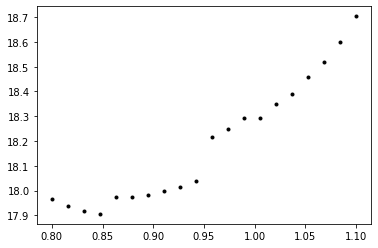

In [10]:
p0 = np.array([0, np.power(10,-4.5), 3.2e-4, 75, 1, 0.075], dtype=np.float32)
Dc,     Dn,   rc, Kn, Hn, pn = p0
p_sub = np.array([Dn, rc, Kn, Hn, pn])
for Hn in np.linspace(0.8,1.1,20):
    p_sub = np.array([Dn, rc, Kn, Hn, pn])
    plt.plot(Hn, fit_fun(p_sub),'k.')

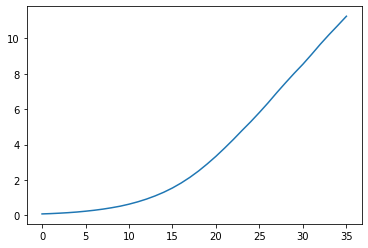

In [43]:
sim_arr, sim_tvc = sim_pad0.sim(p0)
exp_arr = sim_pad2.exp_arr
_, _, n_h, n_w = sim_arr.shape
n_f, s_h, s_w = exp_arr.shape
y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
yslice = slice(y0,y1)
xslice = slice(x0,x1)
diff_arr = np.abs(exp_arr - sim_arr[:,0,yslice,xslice])
diff_sums = diff_arr.sum(axis=1).sum(axis=1)
plt.plot(diff_sums)


In [46]:
# pad_frame_time_df = lineages_df[['pad','frame','time']].groupby(['pad','frame']).agg(np.mean)

def conv_cart_to_polar(x_vec, y_vec):
    # Convert vectors to polar coords
    phi_vec = np.ones(x_vec.shape,dtype=np.float)*np.pi/2
    quad_inds = (x_vec==0 )&(y_vec<0)
    if np.any(quad_inds):
        phi_vec[quad_inds] = 3*np.pi/2
    quad_inds = x_vec > 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    quad_inds = x_vec < 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.pi + np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    phi_vec[phi_vec<0] = phi_vec[phi_vec<0]+2*np.pi
    r_vec = np.sqrt(np.power(y_vec,2) + np.power(x_vec,2))
    return phi_vec, r_vec

def calc_rates(im_arr, im_diff_tvc):
    n_frames, h, w = im_arr.shape
    x_vec, y_vec = (4500/scale)*np.array(list(itt.product(np.arange(h)-(h-1)/2, np.arange(w)-(w-1)/2))).T
    phi_vec, r_vec = conv_cart_to_polar(x_vec, y_vec)
    phi_vec = np.tile(phi_vec, n_frames-1)
    r_vec = np.tile(r_vec, n_frames-1)
    pad_vec = pad_ind*np.ones(t_vec.shape)
    f_vec = np.repeat(frame_vec[:-1], h*w)
    im_diff = np.diff(im_arr,axis=0)/im_arr[:-1,:,:]
    diff_vec = im_diff.flatten()/im_diff_tvc
    return diff_vec, phi_vec, r_vec

def slice_sim(sim_arr, exp_arr):
    _, n_h, n_w = sim_arr.shape
    n_f, s_h, s_w = exp_arr.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    yslice = slice(y0,y1)
    xslice = slice(x0,x1)
    return sim_arr[:,yslice,xslice]

scale = np.power(2,4)
scale_factor = (4/2.475)*(scale/4500)
sf = np.int(1/scale_factor)
start_f, end_f = 5, 41
frame_vec = np.arange(start_f, end_f)
df_list = []
pads_vec = [0,2,9]
sim_vec = [sim_pad0, sim_pad2, sim_pad8]
for i in [0,1,2]:
    pad_ind = pads_vec[i]
    print(pad_ind)
    sim_pad = sim_vec[i]
    im_sim, t_vec = sim_pad.sim(p0)
    im_exp = sim_pad.exp_arr
    im_sim = im_sim[:,0,:,:]
    im_sim = slice_sim(im_sim, im_exp)
    n_frames, h, w = im_sim.shape
    t_diff_vec = np.repeat(np.diff(t_vec), h*w)
    n_data = len(t_diff_vec)
    t_vec = np.tile(np.repeat(t_vec[:-1], h*w),2)
    sim_rates, sim_phi_vec, sim_r_vec = calc_rates(im_sim, t_diff_vec)
    exp_rates, exp_phi_vec, exp_r_vec = calc_rates(im_exp, t_diff_vec)
    pad_vec = pad_ind*np.ones(n_data*2)
    f_vec = np.tile(np.repeat(frame_vec[:-1], h*w),2)
    type_vec = np.repeat(np.array(['sim','exp']),(n_data,))
    diff_vec = np.concatenate([sim_rates, exp_rates])
    occ_vec = np.concatenate([im_sim[:-1,:,:].flatten().astype(np.float), im_exp[:-1,:,:].flatten().astype(np.float)])
    phi_vec = np.concatenate([sim_phi_vec, exp_phi_vec])
    r_vec = np.concatenate([sim_r_vec, exp_r_vec])
    print([xx.shape for xx in [pad_vec,f_vec,t_vec,occ_vec,diff_vec,phi_vec,r_vec,type_vec]])
    df_tmp = pd.DataFrame(dict(zip(['pad','frame','time','density','rate','phi','radius','kind'],
                                   [pad_vec,f_vec,t_vec,occ_vec,diff_vec,phi_vec,r_vec,type_vec])))
    df_list.append(df_tmp)
dwn_rate_df = pd.concat(df_list, ignore_index=True).reset_index()

0
[(9100,), (9100,), (9100,), (9100,), (9100,), (9100,), (9100,), (9100,)]
2


/home/jmp/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/bdf.py:404: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


[(2800,), (2800,), (2800,), (2800,), (2800,), (2800,), (2800,), (2800,)]
9
[(22680,), (22680,), (22680,), (22680,), (22680,), (22680,), (22680,), (22680,)]


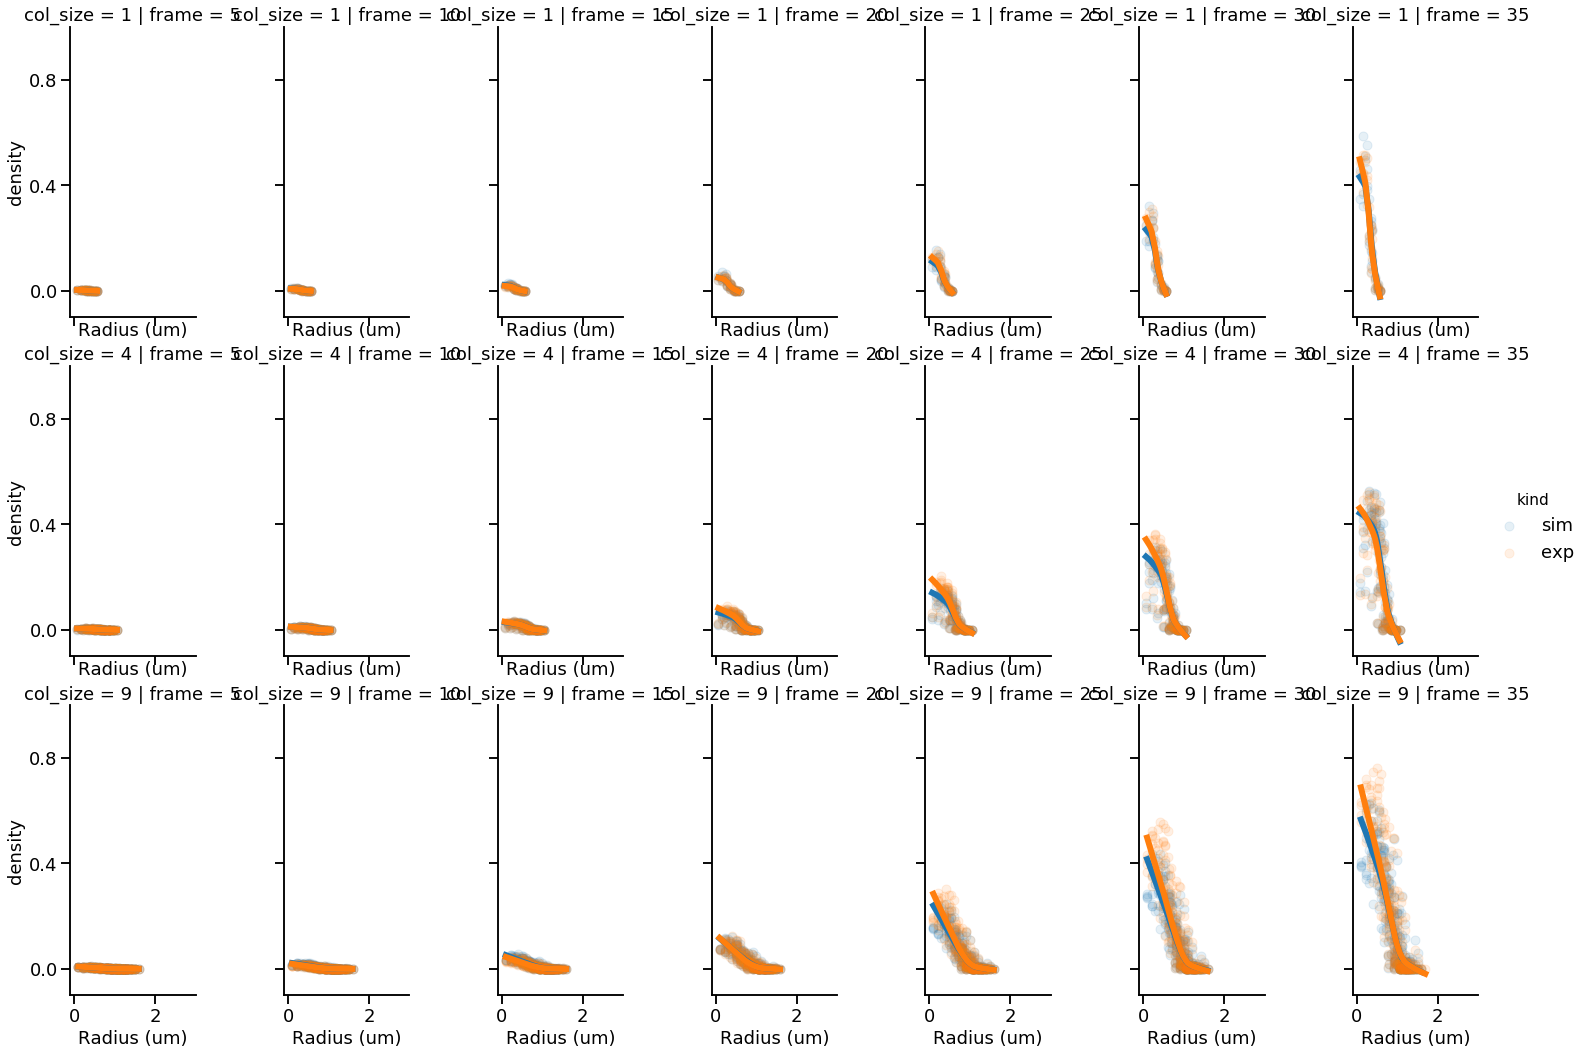

In [48]:
import seaborn as sns
plot_df = dwn_rate_df.loc[(dwn_rate_df.frame>1)&(np.mod(dwn_rate_df.frame,5)==0),:]
plot_df = plot_df.loc[False==np.isnan(plot_df.rate.values),:]

gb_pad_size = fit_df.loc[slice(0,9),['pad','pad_size','col_size']].groupby('pad_size')
plot_gb_pad = plot_df.groupby('pad')
pad_df = gb_pad_size.get_group(4).loc[[0,2,9],:]
#     plt.figure(figsize=(20,18))
sub_plot_df = pd.concat([plot_gb_pad.get_group(xx) for xx in pad_df.pad.values])
sub_plot_df = sub_plot_df.assign(col_size=lambda x : [pad_df.loc[xx,'col_size'] for xx in x.pad.values.astype(np.int)])
sub_plot_df.loc[:,'rate'] = sub_plot_df.loc[:,'rate']*3600
sub_plot_df.loc[:,'radius'] = sub_plot_df.loc[:,'radius']/2e3
g = sns.lmplot(data=sub_plot_df, y='density', x='radius',hue='kind', row='col_size',col='frame',lowess=True,scatter=True,
               aspect=0.6,height=5,scatter_kws={'alpha':0.11},line_kws={'lw':6})
g.set(
    ylim=(-0.1,1),
      yticks=(0,0.4,0.8),
#       yticklabels=["".format(xx) for xx in np.linspace(-5e-5,3.5e-4,4)],
      xlim=(-0.1,3),
      xlabel='Radius (um)')

In [15]:
# Write a script to fit a model of growth rate decay to each colony's observed growth rate
# and rather than just fit a line to a cloud of points, make distributions for each time point
# and scale the error with the std of each time point. I think you should first try to fit the curve to
# an order 3 polynomial. With this fit, you're only trying to capture peak rate and decay slope, which you
# can calculate from the polyomial fit if you're happy with it.
# med_v_df = pd.read_csv('../../../microscope-movie-analysis/fluor_bootstrapped_means.csv')
n_poly = 7
n_pads = 11
pad_size_vec = np.power(np.array([2,2,3,3,5,5,5,3,2]),2)
pad_vec =               np.array([0,2,3,4,5,5,6,7,8])
pov_vec =               np.array([0,2,3,4,5,6,7,8,9])
col_size_vec = np.power(np.array([2,1,2,2,2,2,3,3,2]),2)
x0_vec = np.array([1/2,1/2,1/8,1/2,1/40,6/8,1/10,1/2,1/2])
y0_vec = np.array([1/2,])
# pad_share_vec = np.array([0,1,0,1,0,1,1,0,0,0,1])
pad_info_columns = ['pad', 'pad_size', 'col_size', 'pov', 'x0', 'x1', 'y0', 'y1']
columns = pad_info_columns
fit_df = pd.DataFrame(index=np.arange(n_pads),columns=columns)
fit_df.loc[:,'pad'] = np.arange(n_pads)
fit_df.loc[:,'pad_size'] = pad_size_vec
fit_df.loc[:,'col_size'] = col_size_vec
fit_df.loc[:,'pad_share'] = pad_share_vec

In [35]:
fit_df

,pad,pad_size,col_size,pad_share
0,0,4,4,0
1,1,4,4,1
2,2,4,1,0
3,3,9,4,1
4,4,9,4,0
5,5,25,4,1
6,6,25,4,1
7,7,25,4,0
8,8,9,9,0
9,9,4,9,0


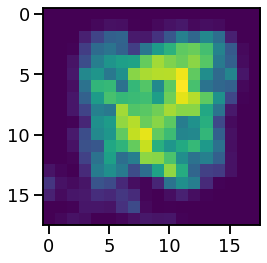

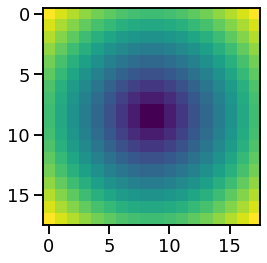

In [49]:
im_arr = sim_pad8.exp_arr
n_frames, h, w = im_arr.shape
x_vec, y_vec = (4500/scale)*np.array(list(itt.product(np.arange(h)-(h-1)/2, np.arange(w)-(w-1)/2))).T
phi_vec, r_vec = conv_cart_to_polar(x_vec, y_vec)
plt.imshow(im_arr[-1,:,:])
plt.figure()
plt.imshow(np.reshape(r_vec,(h,w)))